# Import labries 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16

In [2]:
from tensorflow.keras.applications import Xception

# Read input images and assign labels based on folder names

In [3]:
print(os.listdir("images/"))

SIZE = 256  #Resize images

['test', 'train']


# Capture training data and labels into respective lists

In [4]:
train_images = []
train_labels = [] 

for directory_path in glob.glob("images/train/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img = cv2.imread(img_path)#, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)



cats
images/train\cats\01-kitten-cuteness-1.jpg
images/train\cats\1209389.jpg
images/train\cats\33326dcddbf15c56d631e374b62338dc.jpg
images/train\cats\94041.jpg
images/train\cats\cute-cats-0.jpg
dogs
images/train\dogs\dog-puppy-on-garden-royalty-free-image-1586966191.jpg
images/train\dogs\download.jpg
images/train\dogs\entertainment-2014-08-biscuit-kat-main.jpg
images/train\dogs\fa41ace1ab4cde11018a9b224e488806.jpg
images/train\dogs\images (1).jpg


In [5]:
cv2.imshow("yo",train_images[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

# Convert lists to arrays  

In [5]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Capture test/validation data and labels into respective lists

In [31]:
test_images = []
test_labels = [] 
for directory_path in glob.glob("images/test/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path)#, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

# Convert lists to arrays

In [32]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Encode labels from text to integers.

In [33]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

# Split data into test and train datasets (already split but assigning to meaningful convention)

In [34]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

# Normalize pixel values to between 0 and 1

In [35]:
x_train, x_test = x_train / 255.0, x_test / 255.0

# One hot encode y values for neural network

In [36]:
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [37]:
y_train

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [38]:
y_train_one_hot

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

# Load model wothout classifier/fully connected layers

In [39]:
#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [40]:
for layer in VGG_model.layers:
    print(layer)

In [41]:
VGG_model.save("vgg16.h5")

# Now, let us use features from convolutional network for RF

In [42]:
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_RF = features #This is our X input to RF

In [43]:
feature_extractor.shape,features.shape

((10, 8, 8, 512), (10, 32768))

In [44]:
X_for_RF.shape

(10, 32768)

# Model

In [45]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

In [46]:
import pickle
pickle.dump(RF_model, open('RF_model.pkl','wb'))

# Loading model to compare the results
model = pickle.load(open('RF_model.pkl','rb'))

# Accuracy

Accuracy =  1.0


<AxesSubplot:>

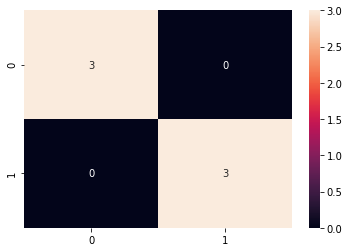

In [47]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

# Random img test

The prediction for this image is:  ['dogs']
The actual label for this image is:  dogs


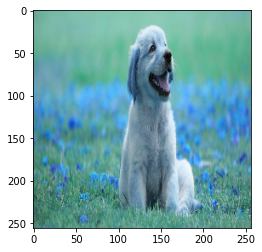

In [48]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])

# try

In [1]:
import pickle,keras,cv2
import numpy as np

In [2]:
VGG_model=keras.models.load_model(
    "vgg16.h5", custom_objects=None, compile=True, options=None
)
model = pickle.load(open('RF_model.pkl','rb'))

In [3]:
train_labels=['cats','cats','cats','cats','cats','dogs','dogs','dogs','dogs','dogs']

In [4]:
img = cv2.imread("images/train/cats/01-kitten-cuteness-1.jpg")      
img = cv2.resize(img, (256, 256))

In [5]:
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = model.predict(input_img_features)[0] 
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", train_labels[prediction_RF])

The prediction for this image is:  0
The actual label for this image is:  cats
